In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Load your DataFrame here
final_df = pd.read_csv('1day_data_sentiment_type1.csv')  # Assuming data is loaded into final_df

# Convert index to datetime if necessary
final_df['date'] = pd.to_datetime(final_df['date'])
final_df.set_index('date', inplace=True)


# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices = final_df['close'].values.reshape(-1,1)
scaled_close_prices = scaler.fit_transform(close_prices)

# Prepare dataset using only close prices
def create_dataset(data, time_step=10):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]  # Only close prices
        x.append(a)
        y.append(data[i + time_step, 0])  # Next close value
    return np.array(x), np.array(y)

time_step = 10
X, y = create_dataset(scaled_close_prices, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM [samples, time steps, features]


In [18]:
X.shape

(168, 10, 1)

In [19]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, batch_size=64, epochs=10, verbose=1)


Epoch 1/10
3/3 [==============================] - 3s 8ms/step - loss: 0.3910
Epoch 2/10
3/3 [==============================] - 0s 7ms/step - loss: 0.1457
Epoch 3/10
3/3 [==============================] - 0s 7ms/step - loss: 0.0228
Epoch 4/10
3/3 [==============================] - 0s 7ms/step - loss: 0.0355
Epoch 5/10
3/3 [==============================] - 0s 7ms/step - loss: 0.0463
Epoch 6/10
3/3 [==============================] - 0s 7ms/step - loss: 0.0161
Epoch 7/10
3/3 [==============================] - 0s 7ms/step - loss: 0.0107
Epoch 8/10
3/3 [==============================] - 0s 7ms/step - loss: 0.0176
Epoch 9/10
3/3 [==============================] - 0s 7ms/step - loss: 0.0191
Epoch 10/10
3/3 [==============================] - 0s 7ms/step - loss: 0.0137


In [20]:
# Generate predictions
predicted_prices = model.predict(X)
predicted_prices = scaler.inverse_transform(predicted_prices)  # Correct shape for inverse transformation

# Incorporate predictions into DataFrame
trades = pd.DataFrame(index=final_df.index[time_step+1:])
trades['Predicted'] = predicted_prices.ravel()  # Flatten array
trades['Actual'] = final_df['close'][time_step+1:]

trades['Signal'] = 0
trades['Signal'] = np.where(trades['Predicted'] > trades['Actual'].shift(), 1, -1)


6/6 [==============================] - 1s 3ms/step


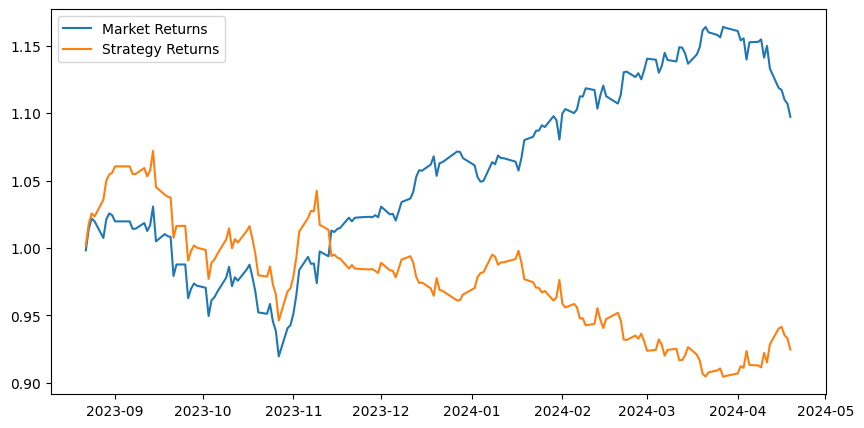

In [21]:
# Calculate returns
trades['Returns'] = trades['Actual'].pct_change()
trades['Strategy'] = trades['Signal'].shift() * trades['Returns']

# Calculate cumulative returns
trades['Cumulative Strategy Returns'] = (1 + trades['Strategy']).cumprod()
trades['Cumulative Market Returns'] = (1 + trades['Returns']).cumprod()

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(trades['Cumulative Market Returns'], label='Market Returns')
plt.plot(trades['Cumulative Strategy Returns'], label='Strategy Returns')
plt.legend()
plt.show()


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assume 'predicted_prices' and 'trades' are already defined from previous steps

# Calculate error metrics
mse = mean_squared_error(trades['Actual'], trades['Predicted'])
mae = mean_absolute_error(trades['Actual'], trades['Predicted'])
rmse = np.sqrt(mse)  # Root Mean Squared Error

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)


Mean Squared Error: 13004.029232514757
Mean Absolute Error: 94.76242501395089
Root Mean Squared Error: 114.03521049445543


In [23]:
import numpy as np

# Calculate MAPE and MdAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate error metrics including MAPE and MdAPE
mape = mean_absolute_percentage_error(trades['Actual'], trades['Predicted'])
mdape = median_absolute_percentage_error(trades['Actual'], trades['Predicted'])

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Median Absolute Percentage Error (MdAPE):", mdape)

Mean Absolute Percentage Error (MAPE): 1.9711920224543882
Median Absolute Percentage Error (MdAPE): 1.7407695291153367
